In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [2]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

## Create AITA Filtered dataset

### Find posts that satisfy the "AITA Filtered" condition

In [23]:
from pymongo import MongoClient
HOST = "localhost"
PORT = 27017
client = MongoClient(host=HOST, port=PORT)
db = client.reddit
subs = db.submissions
cmts = db.comments

In [30]:
from datetime import datetime, timedelta
from tqdm import tqdm

columns = ["_id", "title", "selftext", "score", "YTA_count", "NTA_count", "ESH_count", "NAH_count"]
rows = []

for sub in tqdm(subs.find(), total=subs.count_documents({})):
    filtered = False
    post_id = sub["_id"]
    sub_time = sub["created_utc"]
    judgment_counts = {"YTA": 0, "NTA": 0, "ESH": 0, "NAH": 0}
    top_judgment_scores = {"YTA": 0, "NTA": 0, "ESH": 0, "NAH": 0}
    top_judgment_ids = {"YTA": None, "NTA": None, "ESH": None, "NAH": None}
    
    # Must be retrieved at least 18 hours after the post was created
    if sub["retrieved_on"] - sub["created_utc"] <= timedelta(hours=18): 
        continue
    
    # Only search for top level comments with a judgment label
    for cmt in cmts.find({"parent_id": post_id, 
                          "label": {"$in": ["NTA", "YTA", "ESH", "NAH"]}}):
        
        # Only include comments in the first 18 hours
        time_delta = cmt["created_utc"] - sub["created_utc"]
        if time_delta > timedelta(hours=18):
            continue
        
        # Extract label
        label = cmt["label"]
        judgment_counts[label] += 1
    
    # Group NA and YA
    na = judgment_counts["NTA"] + judgment_counts["NAH"]
    ya = judgment_counts["YTA"] + judgment_counts["ESH"]
    tot = na + ya
    
    # Must have at least 50 judgments and must be balanced (<= 70%)
    if tot >= 50 and na < 0.7 * tot and ya < 0.7 * tot:
        filtered = True
    
    if filtered:
        rows.append([sub["_id"], 
                     sub["title"], 
                     sub["selftext"], 
                     sub["score"],
                     judgment_counts["YTA"],
                     judgment_counts["NTA"],
                     judgment_counts["ESH"],
                     judgment_counts["NAH"]])

100%|██████████████████████████████████| 148691/148691 [05:26<00:00, 455.92it/s]


In [32]:
aitaf_posts = pd.DataFrame(rows, columns=columns)
aitaf_posts.set_index("_id", inplace=True)

In [33]:
aitaf_posts.shape

(2250, 7)

### Find all top-level comments for these posts

In [34]:
columns = ["verdict_id", "link_id", "parent_id", "score", "body", "label"]
rows = []

for post_id in tqdm(aitaf_posts.index):
    sub = subs.find_one({"_id": post_id})
    # Only search for top level comments with a judgment label
    for cmt in cmts.find({"parent_id": post_id, 
                          "label": {"$in": ["NTA", "YTA", "ESH", "NAH"]}}):
        # Only include comments in the first 18 hours
        time_delta = cmt["created_utc"] - sub["created_utc"]
        if time_delta > timedelta(hours=18):
            continue
        
        # Extract comment
        rows.append([
            cmt["_id"],
            cmt["link_id"],
            cmt["parent_id"],
            cmt["score"],
            cmt["body"],
            cmt["label"]
        ])

100%|███████████████████████████████████████| 2250/2250 [00:34<00:00, 64.57it/s]


In [35]:
aitaf_comments = pd.DataFrame(rows, columns=columns)
aitaf_comments.set_index("verdict_id", inplace=True)

In [36]:
aitaf_comments.shape

(490841, 5)

### Add moral foundation scores for posts and comments

In [47]:
aita_posts_scores = pd.read_csv("data/aita/AITA Posts With Moral Foundations.csv", index_col="_id")

In [51]:
aitaf_posts = aitaf_posts[aitaf_posts.index.isin(aita_posts_scores.index)]
aitaf_comments = aitaf_comments[aitaf_comments.parent_id.isin(aitaf_posts.index)]

In [58]:
for f in FOUNDATIONS:
    aitaf_posts[f + "_score"] = \
        aita_posts_scores.loc[aitaf_posts.index, f + "_score"].to_numpy()

/tmp/ipykernel_24021/3198369833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aitaf_posts[f + "_score"] = \


In [70]:
aitaf_comments[[f + "_score" for f in FOUNDATIONS]] = 0

In [72]:
for cmt_id in tqdm(aitaf_comments.index):
    cmt = cmts.find_one({"_id": cmt_id})
    for f in FOUNDATIONS:
        aitaf_comments.loc[cmt_id, f + "_score"] = cmt["mf_scores"][f]

100%|██████████████████████████████████| 466485/466485 [13:52<00:00, 560.03it/s]


## Find verdict for each post

In [38]:
aitaf_posts["verdict"] = ""
aitaf_posts["verdict_id"] = ""
for post_id in tqdm(aitaf_posts.index):
    comments = aitaf_comments[aitaf_comments.link_id == post_id]
    verdict_id = comments.index[np.argmax(comments["score"])]
    verdict = comments.loc[verdict_id, "label"]
    aitaf_posts.loc[post_id, "verdict"] = verdict
    aitaf_posts.loc[post_id, "verdict_id"] = verdict_id

100%|███████████████████████████████████████| 2135/2135 [01:24<00:00, 25.21it/s]


### Save

In [39]:
aitaf_posts.to_csv("data/aita/aita_filtered/aita_filtered_posts_with_MF_scores.csv")
aitaf_comments.to_csv("data/aita/aita_filtered/aita_filtered_comments_with_MF_scores.csv")

## Load data

In [40]:
aitaf_posts = pd.read_csv("data/aita/aita_filtered/aita_filtered_posts_with_MF_scores.csv", index_col="_id")
aitaf_comments = pd.read_csv("data/aita/aita_filtered/aita_filtered_comments_with_MF_scores.csv",
                             index_col="verdict_id")

## Turn scores to binary labels

In [41]:
def threshold_top_x(x, y_score):
    assert 0 <= x and x <= 100
    threshold = np.percentile(y_score, q=x)
    y_pred = [y >= threshold for y in y_score]
    return np.array(y_pred, dtype=int)

In [242]:
topx = 80
for f in FOUNDATIONS:
    aitaf_posts[f] = threshold_top_x(topx, aitaf_posts[f + "_score"])
for f in FOUNDATIONS:
    aitaf_comments[f] = threshold_top_x(topx, aitaf_comments[f + "_score"])

## Odds that posts and verdicts containing the foundation

In [243]:
aitaf_verdicts = aitaf_comments[aitaf_comments.index.isin(aitaf_posts["verdict_id"])]

In [244]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import fisher_exact
from scipy.stats import norm
def odds_ratios(matrix, ci=0.95, log=False):
    # print(fisher_exact(matrix))
    n00, n01 = matrix[0]
    n10, n11 = matrix[1]
    odds_ratio = (n11 * n00) / (n10 * n01)
    lor = np.log(odds_ratio)
    
    se = np.sqrt(1/n00 + 1/n01 + 1/n10 + 1/n11)
    
    p_value = 2 * norm.cdf(-np.abs(lor) / se)
    
    z = np.abs(norm.ppf((1-ci) / 2))
    
    lower = np.exp(lor - z * se)
    upper = np.exp(lor + z * se)
    if log:
        odds_ratio = np.log(odds_ratio)
        lower = np.log(lower)
        upper = np.log(upper)
    return odds_ratio, (lower, upper), p_value

In [245]:
odds_ratios_matrix = pd.DataFrame(0, index=FOUNDATIONS, columns=FOUNDATIONS)
mask = pd.DataFrame(1, index=FOUNDATIONS, columns=FOUNDATIONS)
for post_f in FOUNDATIONS:
    for verdict_f in FOUNDATIONS:
        matrix = contingency_matrix(aitaf_posts[post_f], 
                                    aitaf_verdicts[verdict_f])

        o, ci, pv = odds_ratios(matrix, log=False)
        if pv < 0.05:
            mask.loc[post_f, verdict_f] = 0
        odds_ratios_matrix.loc[post_f, verdict_f] = o

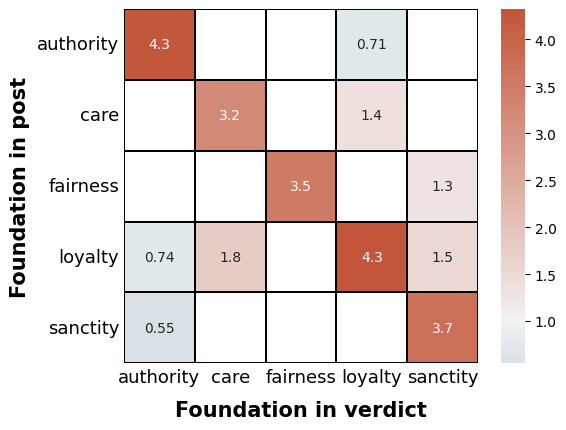

In [246]:
import seaborn as sns
plt.figure(figsize=(6, 4.6))
ax = sns.heatmap(odds_ratios_matrix,                   # data
                 mask=mask,                            # don't plot cells with inf vals
                 square=True,                          # force cells to be square
                 center=1,                             # val for center of the color bar
                 vmin=odds_ratios_matrix.min().min(),# -np.abs(odds_ratios_matrix.max().max()),       # min val for color bar
                 vmax=odds_ratios_matrix.max().max(),# np.abs(odds_ratios_matrix.max().max()),       # max val for color bar
                 cmap=sns.diverging_palette(220, 20, as_cmap=True),                        # color map
                 linewidth=0.003,                        # width of line separating cells
                 linecolor="k",                        # color of line separating cells
                 annot=odds_ratios_matrix,
                 cbar_kws=dict(use_gridspec=False,   # color bar customizations
                               location="right",
                               shrink=1.0,
                               pad=0.05,
                               aspect=15,
                              )
                 )
ax.tick_params(axis='y', which='major', labelsize=13, rotation=0, length=0)
ax.tick_params(axis='x', which='major', labelsize=13, rotation=0, length=0)
ax.set_xlabel("Foundation in verdict", size=15, weight="bold", labelpad=10)
ax.set_ylabel("Foundation in post", size=15, weight="bold", labelpad=5)
plt.show()

## P(verdict contains f1 | post contains f2) 

In [247]:
condprob = pd.DataFrame(0, dtype=float, columns=FOUNDATIONS, index=FOUNDATIONS)
for post_f in FOUNDATIONS:
    for verdict_f in FOUNDATIONS:
        matrix = contingency_matrix(aitaf_posts[post_f], 
                                    aitaf_verdicts[verdict_f])
        cond = (matrix / matrix.sum(1, keepdims=True))
        cond = cond[1, 1]
        condprob.loc[post_f, verdict_f] = cond

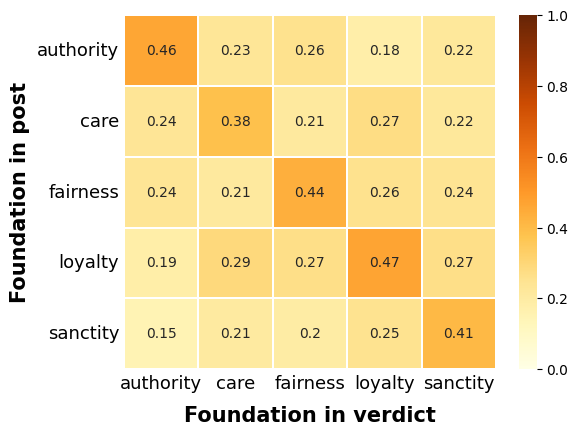

In [248]:
import seaborn as sns
plt.figure(figsize=(6, 4.6))
ax = sns.heatmap(condprob,
                 vmin=0,
                 vmax=1,
                 cmap=sns.color_palette("YlOrBr", as_cmap=True),
                 linewidth=0.003,
                 annot=condprob,
                 )
ax.tick_params(axis='y', which='major', labelsize=13, rotation=0, length=0)
ax.tick_params(axis='x', which='major', labelsize=13, rotation=0, length=0)
ax.set_xlabel("Foundation in verdict", size=15, weight="bold", labelpad=10)
ax.set_ylabel("Foundation in post", size=15, weight="bold", labelpad=5)
plt.show()

## Choose one post with at least one foundation

In [249]:
aitaf_posts_mf = aitaf_posts[aitaf_posts[FOUNDATIONS].sum(1) == 3]
aitaf_posts_mf.shape

(135, 19)

In [250]:
aitaf_posts_mf.sort_values("score", ascending=False).head(15)

,title,selftext,score,YTA_count,NTA_count,ESH_count,NAH_count,authority_score,care_score,fairness_score,loyalty_score,sanctity_score,authority,care,fairness,loyalty,sanctity,verdict,verdict_id
_id,,,,,,,,,,,,,,,,,,,
dwrlls,AITA for outing my ex as gay after she told ev...,I know the title sounds absolutely terrible. \...,33694,70,939,430,5,0.015385,0.820541,0.921484,0.730903,0.512868,0,0,1,1,1,NTA,f7kxlgr
e2nxtz,AITA for not allowing my father to meet my dyi...,I'm a 25 year old guy and my parents were in t...,26362,457,512,133,31,0.164208,0.944463,0.757979,0.529856,0.116859,0,1,1,1,0,NTA,f8wr91f
e1oy5c,"AITA if I ""cancel"" Christmas because I can't a...","Title says it all, sole provider for family, a...",25428,297,298,3,309,0.056936,0.956702,0.736847,0.422432,0.169697,0,1,1,1,0,YTA,f8qwon2
byiwjh,AITA for exposing the real reason my sister an...,"throwaway, and I will be keeping this is Anony...",25376,233,424,180,6,0.044337,0.684629,0.812260,0.693170,0.422051,0,0,1,1,1,NTA,eqi1jkm
dfp1yq,AITA for surrendering my sister's child to pro...,"I'm 26M, my sister is 28F. We're the only fami...",21225,414,336,69,120,0.476049,0.932830,0.233766,0.570902,0.093727,1,1,0,1,0,NTA,f34x191
d6v6mz,AITA for kicking my husband out of the house b...,My husband hid $1500 (some insurance payout) f...,19872,125,913,301,19,0.023280,0.952775,0.799527,0.340265,0.152243,0,1,1,1,0,NTA,f0vo7t7
e0utnu,AITA for not reacting well when I found out my...,I (26F) was married to “Sam” (30M) for three y...,19843,352,197,133,43,0.015536,0.773847,0.697255,0.787457,0.296965,0,0,1,1,1,NAH,f8hmy0u
bhdnls,AITA for sending an explicit video my ex sent ...,Hi AITA. I am going to try to make this as bri...,19240,45,385,296,1,0.021499,0.896185,0.386485,0.534503,0.433282,0,1,0,1,1,ESH,elrys9q
e1622e,AITA for turning my son into the police?,My 16 year old son was catfishing people on th...,15209,584,480,199,7,0.777576,0.947298,0.781017,0.025749,0.230440,1,1,1,0,0,NTA,f8mu06l


In [257]:
post_id = "byiwjh"
post = subs.find_one({"_id": post_id})
print(post["title"], "\n")
print(post["selftext"])
print("\n", "=" * 80, "\n")
comments = aitaf_comments[aitaf_comments.link_id == post_id]
ya_comments = comments[comments.label.isin(["YTA", "ESH"])]
na_comments = comments[comments.label.isin(["NTA", "NAH"])]
print("YA judgments: N =", ya_comments.shape[0])
print("NA judgments: N =", na_comments.shape[0])

AITA for exposing the real reason my sister and her bf broke up. 

throwaway, and I will be keeping this is Anonymous as I can, every name will be fake. 

my sister (cas) 25f and her boyfriend (jon) of 3 years 24m broke up last week, I'm good friends with jon and we chat in a discord server often. I assumed it was a mutual breakup and so asked Jon if he was doing ok, he then asked me if I knew the reason they broke up. I said no and he explained that it was because he was bisexual, he even showed me screenshots where it showed how homophobic my sister is, I was shocked and apologized to him. 

the next day I was scrolling through Facebook and noticed my sister had made a post about the breakup, turns out she is claiming that he cheated on her. she must of blocked him so he could not show the actual truth. 

with Jon's permission I posted all the screenshots on my Facebook page. 
 it caused my parents to call me and tell me I have to take the post down as my sister has had over 30 peopl

In [258]:
from scipy.stats import ttest_ind
for f in FOUNDATIONS:
    print(f)
    result = ttest_ind(ya_comments[f], na_comments[f])
    print("  statistic:", result.statistic)
    print("  pvalue   :", result.pvalue)

authority
  statistic: -1.8371594926382337
  pvalue   : 0.06653904557583401
care
  statistic: 0.6316361939907431
  pvalue   : 0.5277962758108004
fairness
  statistic: -2.235188319708884
  pvalue   : 0.025666803397650862
loyalty
  statistic: 4.383743186674081
  pvalue   : 1.3142873953968184e-05
sanctity
  statistic: 1.2762429641046027
  pvalue   : 0.20222197441787232


sanctity 1.1943251726302573
loyalty 1.8309655519235604
fairness 0.7338918030219995
care 1.130850047755492
authority 0.5074626865671642


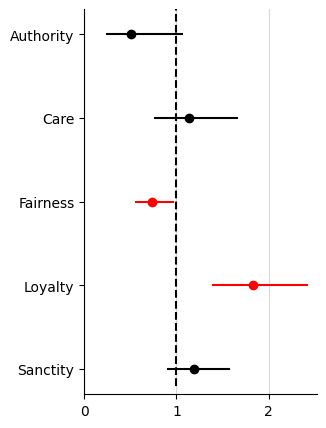

In [259]:
ors = []
pvalues = []
cis = []
fs = []
ya_binary = np.array([1 for _ in range(len(ya_comments))] + 
                     [0 for _ in range(len(na_comments))])
for f in FOUNDATIONS[::-1]:
    matrix = contingency_matrix(
        ya_binary,
        np.hstack((ya_comments[f], na_comments[f]))
    )
    o, ci, pv = odds_ratios(matrix)
    print(f, o)
    ors.append(o)
    cis.append(ci)
    pvalues.append(pv)
    fs.append(f)

plt.figure(figsize=(3, 5))
for i, f, o, p, ci in zip(range(len(fs)), fs, ors, pvalues, cis):
    plt.scatter(o, f, c='r' if p < 0.05 else "k")
    plt.plot((ci[0], ci[1]), (f, f), c='r' if p < 0.05 else "k")
plt.gca().set_xlim(left=0)
plt.grid(axis="x", alpha=0.5)
plt.yticks([0, 1, 2, 3, 4], ["Authority", "Care", "Fairness", "Loyalty", "Sanctity"][::-1])
plt.plot((1, 1), (-0.2, 5.2), c="k", linestyle="--")
plt.ylim([-0.3, 4.3])
sns.despine()

### Count how many posts contain significant odds ratios on two sides of 1

In [210]:
count = 0
for post_id in tqdm(aitaf_posts.index):
    comments = aitaf_comments[aitaf_comments.link_id == post_id]
    ya_comments = comments[comments.label.isin(["YTA", "ESH"])]
    na_comments = comments[comments.label.isin(["NTA", "NAH"])]
    
    ya_binary = np.array([1 for _ in range(len(ya_comments))] + 
                         [0 for _ in range(len(na_comments))])
    lt1, gt1 = 0, 0
    for f in FOUNDATIONS[::-1]:
        f_binary = np.hstack((ya_comments[f], na_comments[f]))
        if f_binary.sum() <= 0: continue
        matrix = contingency_matrix(ya_binary, f_binary)
        if matrix.min().min() <= 0: continue
        o, ci, pv = odds_ratios(matrix)
        if pv < 0.05:
            if o > 1: gt1 += 1
            else: lt1 += 1
    count += gt1 * lt1 > 0

100%|███████████████████████████████████████| 2135/2135 [01:27<00:00, 24.47it/s]


In [211]:
count / aitaf_posts.shape[0]

0.117096018735363